# Taher Muhammedali - 0478012

## Assignment 5 - Task 1 - Data Science ESM

In [1]:
import pandas as pd
import pypsa as pyp
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from urllib.request import urlretrieve
import matplotlib.pyplot as plt

### (a) Import the necessary packages and load the pre-built PyPSA network

In [2]:
fn = "network-assignment-5.nc"
url = "https://tubcloud.tu-berlin.de/s/m73a6SGXEYAsiyY/download/" + fn
urlretrieve(url, fn)

('network-assignment-5.nc', <http.client.HTTPMessage at 0x28c60b949a0>)

In [3]:
n = pyp.Network(fn)

INFO:pypsa.io:Imported network network-assignment-5.nc has buses, carriers, generators, global_constraints, loads, storage_units


### (b) Remove components

In [4]:
n.remove("Generator","OCGT") # Removing OCGT
n.remove("Carrier", "OCGT") # Removing OCGT
n.remove("StorageUnit", "hydrogen storage underground") # Removing simple hydrogen storage underground
n.remove("Carrier", "hydrogen storage underground") # Removing simple hydrogen storage underground
n.remove("GlobalConstraint","CO2Limit") # Removing CO2 constraint

### (c) Add a hydrogen system

In [5]:
n.add("Bus", "hydrogen")    # Adding the Hydrogen Bus
n.add("Link",               # Adding Electrolysis Link to convert electricity back to hydrogen
      "electrolysis",
      bus0="electricity",
      bus1="hydrogen",
      carrier='electrolysis',
      p_nom_extendable=True,
      efficiency=.7,
      capital_cost=50e3, # €/MW/a
      )
n.add("Link",               # Adding Fuel Cell Link to convert hydrogen back to electricity
      "fuel cell",
      bus0="hydrogen",
      bus1="electricity",
      carrier='fuel cell',
      p_nom_extendable=True,
      efficiency=.5,
      capital_cost=120e3, # €/MW/a
      )
n.add(
    "Store",                # Adding Hydrogen Store to the system
    "hydrogen storage",
    bus="hydrogen",
    carrier='hydrogen storage',
    capital_cost=140, # €/MWh/a
    e_nom_extendable=True,
    e_cyclic=True, # cyclic state of charge
)

### (d) Add hydrogen demand

In [6]:
p_set = 333e6/8760  # Dividing 333TWh of hydrogen demand per hour equally across the year
n.add(
    "Load",         # Adding the hydrogen demand to the network
    "hydrogen demand",
    bus="hydrogen",
    carrier="hydrogen",
    p_set=p_set # MW
)

In [7]:
print(f"The total electricity demand in 2015 is{n.loads_t.p['demand'].sum()/1e6: 0.2f}TWh and the given hydrogen demand is 333TWh")
print(f"The average electricity demand per hour in 2015 is{n.loads_t.p['demand'].mean(): 0.0f}MW and the hourly hydrogen demand is{p_set: 0.0f}MW")

The total electricity demand in 2015 is 479.50TWh and the given hydrogen demand is 333TWh
The average electricity demand per hour in 2015 is 54737MW and the hourly hydrogen demand is 38014MW


From the above values we can see that the Hydrogen demand is slightly lower than the Electricity demand in 2015 for Germany, but will play a significant part in influencing our model and analysis.

### (e) Solve the model

In [8]:
n.lopf(solver_name='gurobi') # Solving the model without constraints

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.82s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-28
Read LP format model from file C:\Users\taher\AppData\Local\Temp\pypsa-problem-soxr7ew8.lp
Reading time = 0.52 seconds
obj: 192720 rows, 87608 columns, 381334 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 192720 rows, 87608 columns and 381334 nonzeros
Model fingerprint: 0x5f4bfb7a
Coefficient statistics:
  Matrix range     [1e-04, 6e+00]
  Objective range  [1e-02, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+04, 8e+04]
Presolve removed 91706 rows and 12867 columns
Presolve time: 0.30s
Presolved: 101014 rows, 74741 columns, 276762 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dens

INFO:pypsa.linopf:Optimization successful. Objective value: 7.67e+10


('ok', 'optimal')

In [9]:
round(n.generators.p_nom_opt.div(1e3),2) # The optimal capacity of Generators in GW

Generator
onwind      61.80
offwind    152.19
solar      417.90
Name: p_nom_opt, dtype: float64

In [10]:
round(n.storage_units.p_nom_opt.div(1e3),2) # Optimal Capacity of Battery Storage in GW

StorageUnit
battery storage    56.69
Name: p_nom_opt, dtype: float64

In [11]:
round(n.stores.e_nom_opt.div(1e3),2) # Optimal Energy Capacity of Hydrogen Storage in GW

Store
hydrogen storage    37270.38
Name: e_nom_opt, dtype: float64

In [12]:
print(f"The total cost of the system is €{n.objective/1e9: 0.1f} Billion per annum")

The total cost of the system is € 76.7 Billion per annum


### (f) Add onwind/offwind constraints and rerun

In [13]:
n1 = n.copy()
n1.generators.loc["onwind", "p_nom_max"] = 200e3 #Adding onwind constraints
n1.generators.loc["offwind", "p_nom_max"] = 70e3 #Adding offshore constraints

In [14]:
n1.lopf(solver_name='gurobi') # Solving with new constraints

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.28s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\taher\AppData\Local\Temp\pypsa-problem-l1jl7s3f.lp
Reading time = 0.44 seconds
obj: 192720 rows, 87608 columns, 381334 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 192720 rows, 87608 columns and 381334 nonzeros
Model fingerprint: 0x1fa140aa
Coefficient statistics:
  Matrix range     [1e-04, 6e+00]
  Objective range  [1e-02, 2e+05]
  Bounds range     [7e+04, 2e+05]
  RHS range        [3e+04, 8e+04]
Presolve removed 91706 rows and 12867 columns
Presolve time: 0.28s
Presolved: 101014 rows, 74741 columns, 276762 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 7
 AA' NZ     : 2.371e+05
 Factor NZ  : 1.685e+06 (roughly 80 MB of memory)
 Facto

INFO:pypsa.linopf:Optimization successful. Objective value: 7.81e+10


('ok', 'optimal')

In [15]:
round(n1.generators.p_nom_opt.div(1e3),2) # The optimal capacity of Generators in GW

Generator
onwind     200.00
offwind     70.00
solar      418.81
Name: p_nom_opt, dtype: float64

In [16]:
round(n1.storage_units.p_nom_opt.div(1e3),2) # Optimal Capacity of Battery Storage in GW

StorageUnit
battery storage    54.71
Name: p_nom_opt, dtype: float64

In [17]:
round(n1.stores.e_nom_opt.div(1e3),2) # Optimal Energy Capacity of Hydrogen Storage in GW

Store
hydrogen storage    40600.26
Name: e_nom_opt, dtype: float64

In [18]:
print(f"The total cost of the system with new constraints is €{n1.objective/1e9: 0.1f} Billion per annum")

The total cost of the system with new constraints is € 78.1 Billion per annum


f1) Yes, we can see from the above values that the limits for both offshore and onshore are reached in this model.
Offwind capacity being limited severely from 152GW to 70GW has caused the Onwind capacity to increase from 61.8GW to its capacity of 200GW. There is only a slight increase in Solar capacity.

In [79]:
print(f"f2) We can see that the new model with these constraints only increase the system costs by €{(n1.objective-n.objective)/1e9: 0.2f} Billion,{((n1.objective-n.objective)/n.objective)*100: 0.2f}%")

f2) We can see that the new model with these constraints only increase the system costs by € 1.39 Billion, 1.82%


In [20]:
def system_cost(n): #Function for calculating system costs
    tsc = n.statistics.capex() + n.statistics.opex()
    return tsc.droplevel(0).div(1e6) # million €/a

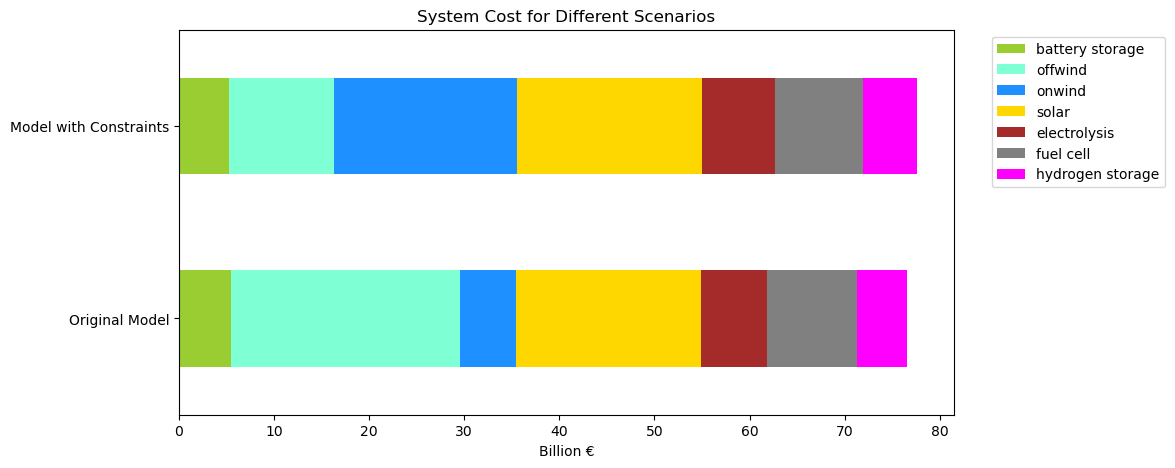

In [21]:
#Plotting system costs for both scenarios for comparison
colordict = n.carriers.color.to_dict()
colordict.update({'hydrogen storage': 'magenta', 'electrolysis': 'brown','fuel cell':'grey'})
test = system_cost(n)
test1 = system_cost(n1)
xyz = pd.DataFrame()
xyz['Original Model'] = test / 1e3
xyz["Model with Constraints"] = test1/1e3

xyz.T.plot.barh(stacked=True, figsize=(10,5), color=colordict)
plt.title('System Cost for Different Scenarios')
plt.xticks(rotation=0)
plt.xlabel('Billion €')
plt.legend(loc='best')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

f3) Visualizing the differences in capacities built

In [22]:
#Copying values to a separate df
x = n.generators.p_nom_opt.div(1e3)
x = x.append(n.storage_units.p_nom_opt.div(1e3))
x = x.append(n.links.p_nom_opt.div(1e3))
x = x.to_frame()
x = x.rename(columns={'p_nom_opt': 'Original'})
y = n1.generators.p_nom_opt.div(1e3)
y = y.append(n1.storage_units.p_nom_opt.div(1e3))
y = y.append(n1.links.p_nom_opt.div(1e3))
x['WithConstraints'] = y

<AxesSubplot: title={'center': 'Comparison of capacities built with each model'}, xlabel='Generators, Storages & Links', ylabel='Capacity (GW)'>

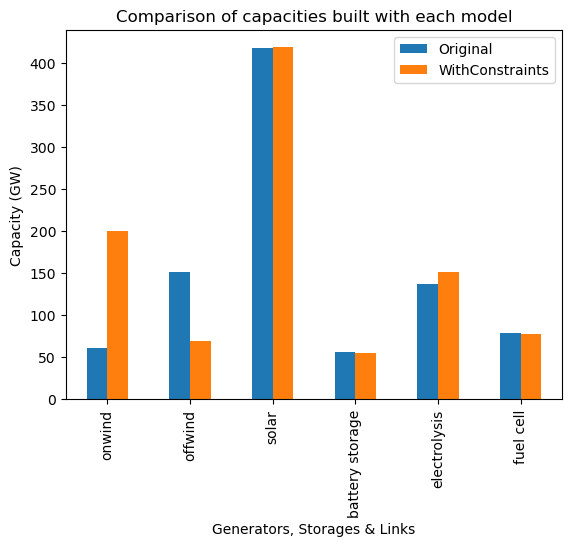

In [23]:
# Plotting the difference in capacities built in each scenario. Hydrogen storage is in separate chart
x.plot.bar(title='Comparison of capacities built with each model',xlabel='Generators, Storages & Links',ylabel='Capacity (GW)')

Text(0, 0.5, 'Capacity (TW)')

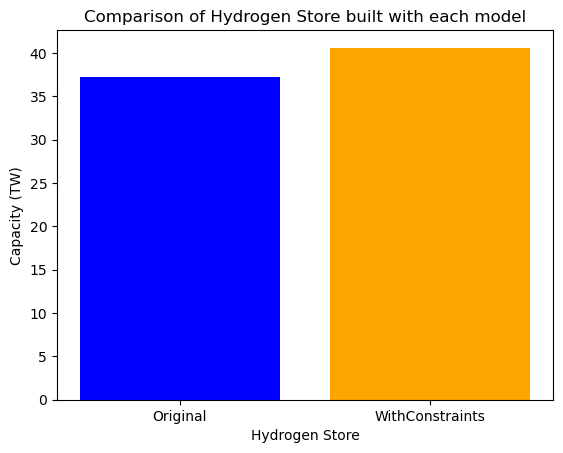

In [24]:
# Plotting the difference in Hydrogen Store built in each scenario.
plt.bar(x=['Original','WithConstraints'],
        height=[n.stores.e_nom_opt.div(1e6).item(),n1.stores.e_nom_opt.div(1e6).item()],
        color=['blue','orange'],)
plt.title('Comparison of Hydrogen Store built with each model')
plt.xlabel('Hydrogen Store')
plt.ylabel('Capacity (TW)')

### (g) Plot SOCs - Hydrogen store and Battery Storage

<AxesSubplot: title={'center': 'SOC for Hydrogen Store in 2015'}, xlabel='2015', ylabel='Energy Capacity (TWh)'>

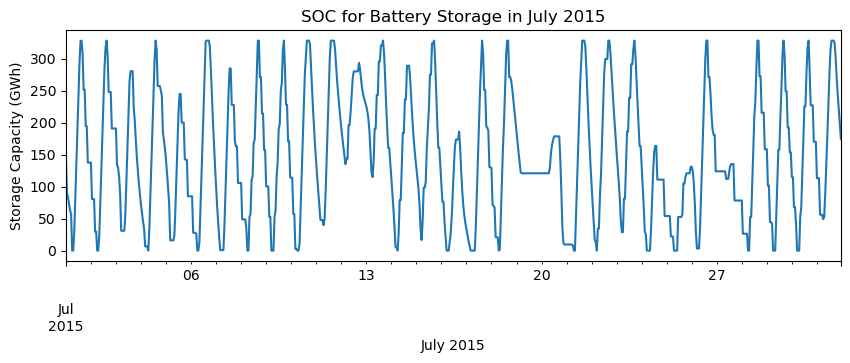

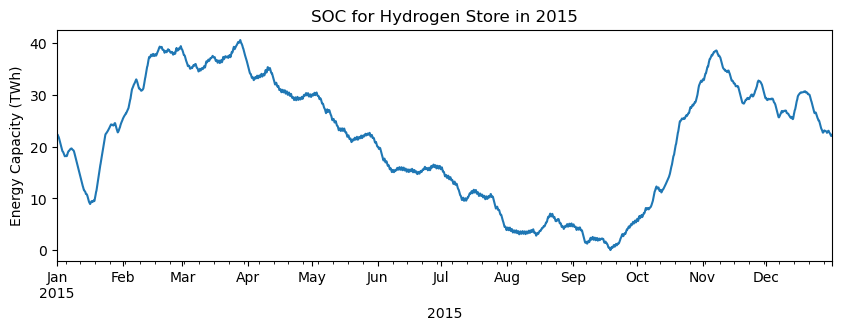

In [25]:
#Plotting SOC for Battery storage for July 2015
n1.storage_units_t.state_of_charge['2015-07-01':'2015-07-31'].div(1e3).plot(title='SOC for Battery Storage in July 2015',
                                                                            xlabel='July 2015',
                                                                            ylabel='Storage Capacity (GWh)',
                                                                            legend=False,
                                                                            figsize=(10,3))
#Plotting SOC for Hydrogen storage for 2015
(n1.stores_t.p.div(1e6).cumsum() + abs(n1.stores_t.p.div(1e6).cumsum().min())).plot(title='SOC for Hydrogen Store in 2015',
                                                                                    xlabel='2015',
                                                                                    ylabel='Energy Capacity (TWh)',
                                                                                    legend=False,
                                                                                    figsize=(10,3))

### (h) Plot Hydrogen production and consumption

<AxesSubplot: title={'center': 'Hydrogen Production from Electrolysis'}, xlabel='2015', ylabel='GW (Mt)'>

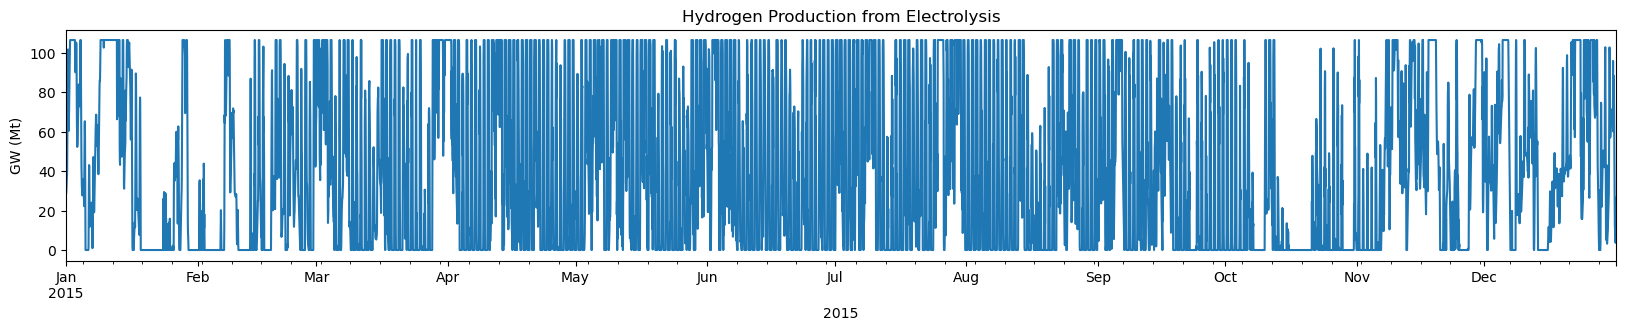

In [26]:
#Hydrogen Production plot at P1 for electrolysis link
n1.links_t.p1['electrolysis'].div(1e3).mul(-1).plot(title='Hydrogen Production from Electrolysis',
                                                    xlabel='2015',
                                                    ylabel='GW (Mt)',
                                                    figsize=(20, 3))

<AxesSubplot: title={'center': 'Hydrogen Consumption from Fuel Cell'}, xlabel='2015', ylabel='GW (Mt)'>

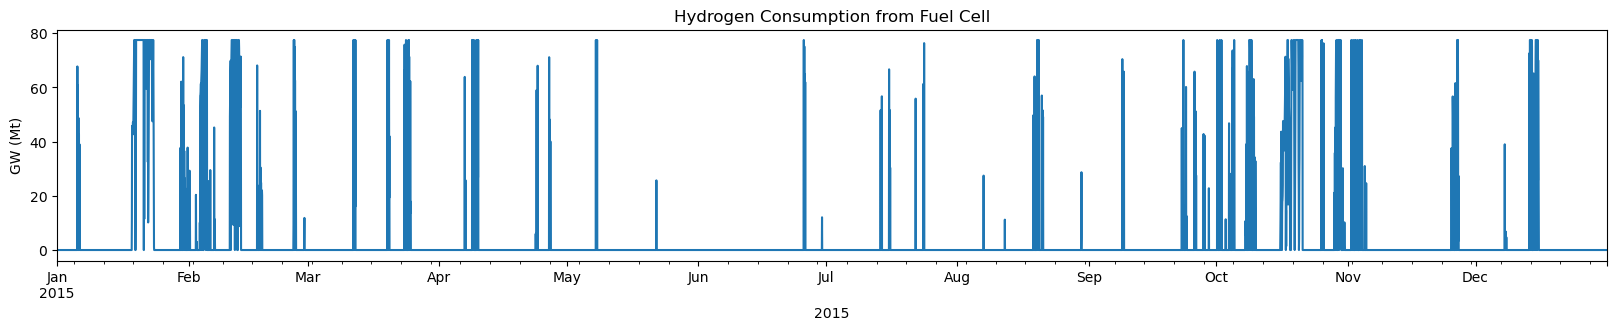

In [27]:
#Hydrogen Consumption plot at P0 for fuel cell link
n1.links_t.p0['fuel cell'].div(1e3).plot(title='Hydrogen Consumption from Fuel Cell',
                                         xlabel='2015',
                                         ylabel='GW (Mt)',
                                         figsize=(20, 3))

Text(0.5, 0, '2015')

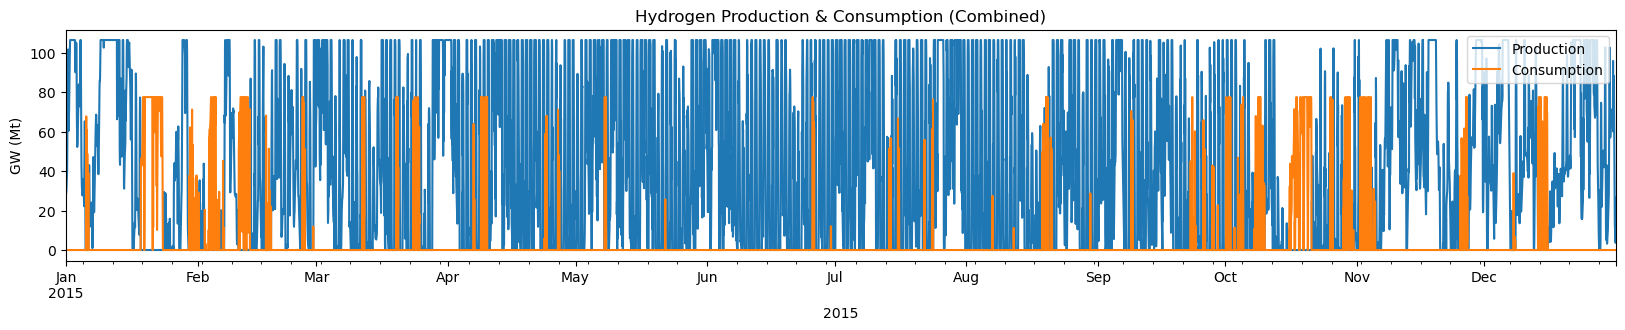

In [28]:
#Combined plot of above two plots
n1.links_t.p1['electrolysis'].div(1e3).mul(-1).plot(title='Hydrogen Production & Consumption (Combined)',
                                                    ylabel='GW (Mt)',
                                                    label='Production',
                                                    figsize=(20, 3))
n1.links_t.p0['fuel cell'].div(1e3).plot(label='Consumption',)
plt.legend(loc='upper right')
plt.xlabel('2015')

### (i) Utilisation rate of electrolysis and fuel cell

In [29]:
#Utilisation rate Calculations Electrolysis
electroutil = n1.links_t.p1['electrolysis'].div(1e3).mul(-1)
electroutil = electroutil.to_frame()
electroutil['Utilisation (%)'] = (electroutil['electrolysis'] / electroutil['electrolysis'].max()) * 100
print(f"The average utilisation rate of electrolysis is {electroutil['Utilisation (%)'].mean():0.2f}%")

The average utilisation rate of electrolysis is 39.73%


In [30]:
#Utilisation rate Calculations Fuel Cell
fuelcutil = n1.links_t.p0['fuel cell'].div(1e3)
fuelcutil = fuelcutil.to_frame()
fuelcutil['Utilisation (%)'] = (fuelcutil['fuel cell'] / fuelcutil['fuel cell'].max()) * 100
print(f"The average utilisation rate of fuel cells is {fuelcutil['Utilisation (%)'].mean():0.2f}%")

The average utilisation rate of fuel cells is 5.47%


In [31]:
#Utilisation rate Calculations based on monthly average
electroutilmean = electroutil['Utilisation (%)'].resample('M').mean()
print("The monthly average utilisation rate of electrolysis in % is as follows:")
round(electroutilmean,2)

The monthly average utilisation rate of electrolysis in % is as follows:


snapshot
2015-01-31    43.09
2015-02-28    26.38
2015-03-31    42.10
2015-04-30    44.89
2015-05-31    48.58
2015-06-30    41.55
2015-07-31    51.12
2015-08-31    35.84
2015-09-30    35.66
2015-10-31    14.94
2015-11-30    43.90
2015-12-31    47.61
Freq: M, Name: Utilisation (%), dtype: float64

<AxesSubplot: title={'center': 'Monthly average Utilisation rate of Electrolysis'}, xlabel='2015', ylabel='(%)'>

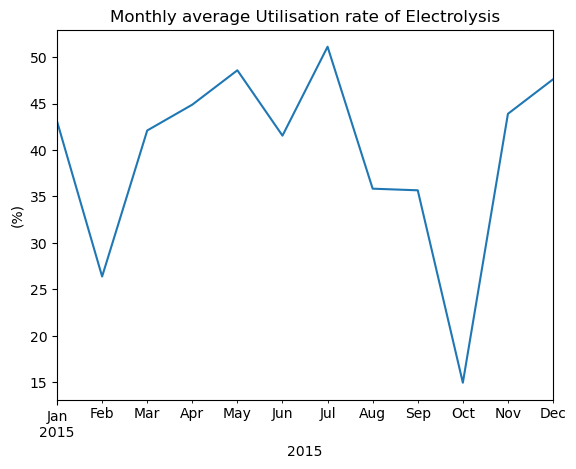

In [32]:
#Plot of above monthly data
electroutilmean.plot(title='Monthly average Utilisation rate of Electrolysis',xlabel='2015',ylabel='(%)')

In [33]:
#Utilisation rate Calculations based on monthly average
fuelcutilmean = fuelcutil['Utilisation (%)'].resample('M').mean()
print("The monthly average utilisation rate of fuel cells in % is as follows:")
round(fuelcutilmean,2)

The monthly average utilisation rate of fuel cells in % is as follows:


snapshot
2015-01-31    15.38
2015-02-28    12.94
2015-03-31     3.21
2015-04-30     2.38
2015-05-31     0.45
2015-06-30     0.52
2015-07-31     0.80
2015-08-31     1.31
2015-09-30     1.46
2015-10-31    18.51
2015-11-30     4.96
2015-12-31     4.06
Freq: M, Name: Utilisation (%), dtype: float64

<AxesSubplot: title={'center': 'Monthly average Utilisation rate of Fuel Cells'}, xlabel='2015', ylabel='(%)'>

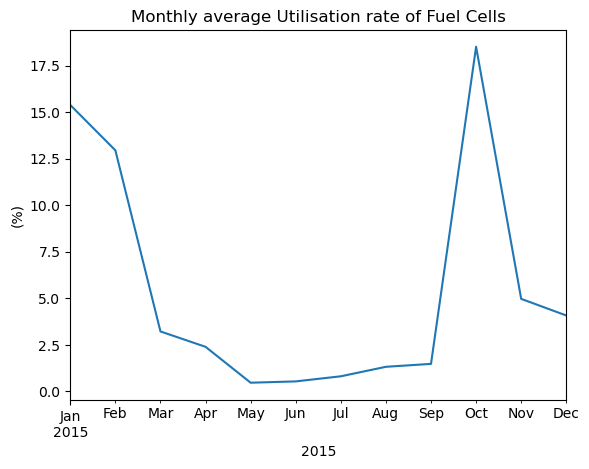

In [34]:
#Plot of above monthly data
fuelcutilmean.plot(title='Monthly average Utilisation rate of Fuel Cells',xlabel='2015',ylabel='(%)')

Text(0.5, 1.0, 'Renewables Power vs Electrolysis Utilisation')

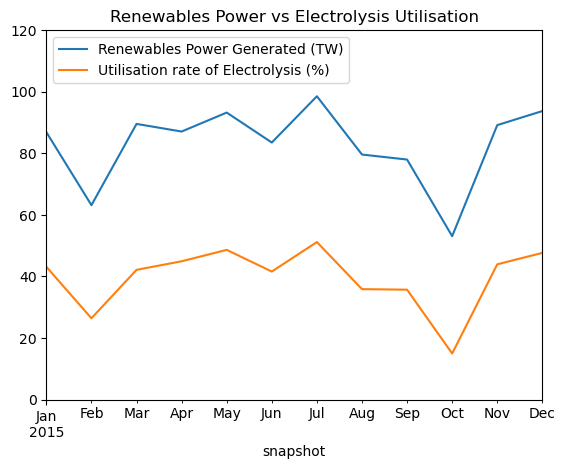

In [35]:
(n1.generators_t.p.resample('M').sum().sum(axis=1)/1e6).plot(label='Renewables Power Generated (TW)')# Power Generated by Renewables every month
electroutilmean.plot(label='Utilisation rate of Electrolysis (%)') # Plot of Utilisation for electrolysis
plt.legend(loc='upper left')
plt.ylim(0,120)
plt.title('Renewables Power vs Electrolysis Utilisation')

We can notice that utilisation rate of fuel cells is quite high in the months of Jan, Feb and Oct, this correlates to the lack of renewables production during those months specifically in Feb 7 Oct.
Similarly, the utilisation rate of electrolysis is highest in the months of May, July and Dec, this correlates to the high energy production from renewables during those months.
We can see how the renewables production plot follows a similar trend to the electrolysis utilisation plot.

In [71]:
n.links.p_nom_max

Link
electrolysis    inf
fuel cell       inf
Name: p_nom_max, dtype: float64

### (j) Plot Price duration curves for electricity and hydrogen

Text(0.5, 0, '%')

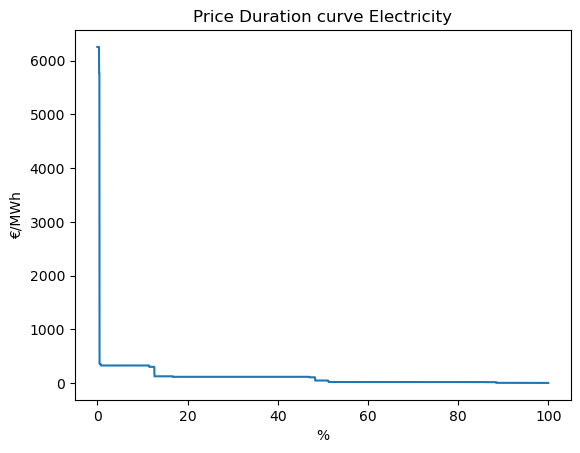

In [94]:
# Price duration curve
interval = 100/8760
values = [i*interval for i in range(8760)]
y = n1.buses_t.marginal_price['electricity'].sort_values(ascending=False).reset_index(drop=True)
plt.plot(values,y)
plt.title('Price Duration curve Electricity')
plt.ylabel('€/MWh')
plt.xlabel('%')

Text(0.5, 0, '%')

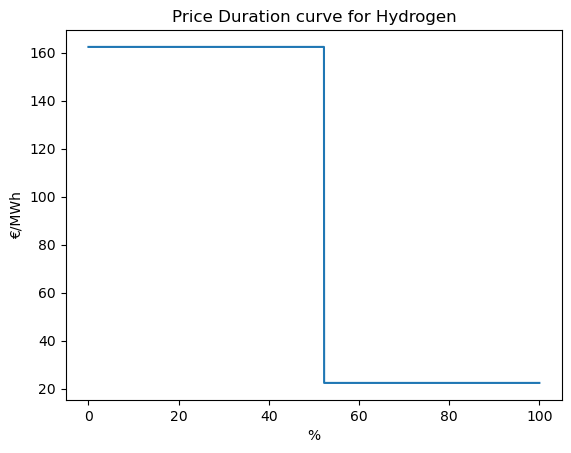

In [97]:
# Price duration curve
interval = 100/8760
values = [i*interval for i in range(8760)]

y = n1.buses_t.marginal_price['hydrogen'].sort_values(ascending=False).reset_index(drop=True)
plt.plot(values,y)
plt.title('Price Duration curve for Hydrogen')
plt.ylabel('€/MWh')
plt.xlabel('%')

In [38]:
months = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

For onwind, the month with max value is Jan
For onwind, the month with min value is Aug
For offwind, the month with max value is Dec
For offwind, the month with min value is Aug
For solar, the month with max value is Oct
For solar, the month with min value is Apr


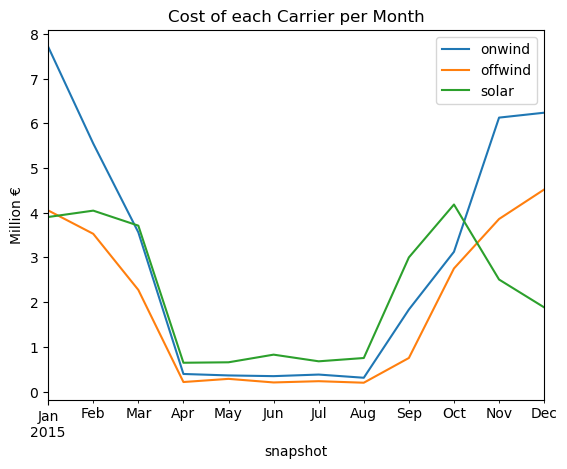

In [158]:
for carrier in ['onwind','offwind','solar']:
    x = (n1.generators_t.p[carrier] * n1.buses_t.marginal_price['electricity']).div(1e6).resample('M').mean()
    x.plot(label=carrier)
    print(f"For {carrier}, the month with max value is {months.get(x.idxmax().month)}")
    print(f"For {carrier}, the month with min value is {months.get(x.idxmin().month)}")

plt.title('Cost of each Carrier per Month')
plt.ylabel('Million €')
plt.legend(loc='upper right')

In [159]:
#Calculations for finding the months where max and min values were reached
df = n1.buses_t.marginal_price['electricity']
elecmax = df[df == df.max(axis=0)].index.month.unique().to_list()
elecmin = df[df == df.min(axis=0)].index.month.unique().to_list()

for item in elecmax:
        print(f"The months where the highest electricity price is reached - {months.get(item)}, €{df.max():0.1f}")
for item in elecmin:
    print(f"The months where the lowest electricity price is reached - {months.get(item)}, €{df.min():0.1f}")

The months where the highest electricity price is reached - Jan, €6256.5
The months where the lowest electricity price is reached - Mar, €0.0
The months where the lowest electricity price is reached - Apr, €0.0
The months where the lowest electricity price is reached - May, €0.0
The months where the lowest electricity price is reached - Jun, €0.0
The months where the lowest electricity price is reached - Jul, €0.0
The months where the lowest electricity price is reached - Aug, €0.0
The months where the lowest electricity price is reached - Sep, €0.0
The months where the lowest electricity price is reached - Oct, €0.0


In [160]:
#Calculations for finding the months where max and min values were reached
df1 = n1.buses_t.marginal_price['hydrogen']
elecmax = df1[df1 == df1.max(axis=0)].index.month.unique().to_list()
elecmin = df1[df1 == df1.min(axis=0)].index.month.unique().to_list()

for item in elecmax:
    print(f"The months where the highest hydrogen price is reached - {months.get(item)}, €{df1.max():0.1f}")
for item in elecmin:
    print(f"The months where the lowest hydrogen price is reached - {months.get(item)}, €{df1.min():0.1f}")

The months where the highest hydrogen price is reached - Sep, €162.3
The months where the lowest hydrogen price is reached - Apr, €22.3
The months where the lowest hydrogen price is reached - May, €22.3


### (k) Demand-weighted average price of electricity and hydrogen

In [41]:
#Calculating DWAP
print(f"The demand weighted average price of electricity is €{(n1.buses_t.marginal_price['electricity']*n1.loads_t.p['demand']).sum()/n1.loads_t.p['demand'].sum():0.2f}")

The demand weighted average price of electricity is €121.65


In [42]:
#Calculating DWAP
print(f"The demand weighted average price of hydrogen is €{(n1.buses_t.marginal_price['hydrogen']*n1.loads_t.p['hydrogen demand']).sum()/n1.loads_t.p['hydrogen demand'].sum():0.2f}")

The demand weighted average price of hydrogen is €95.47


Hydrogen's price is lower than Electricity's price. Due to fluctuation in demand and renewables potential, some of the electricity demand has to be fulfilled using Fuel Cells which is an expensive process which causes the price of Electricity to be much higher than Hydrogen. We can see that in Feb for a few days the price of electricity is significantly higher than anytime throughout the year which has also skewed the calculations.

### (l) Power consumption and injection

Text(0.5, 0, 'Power (GW)')

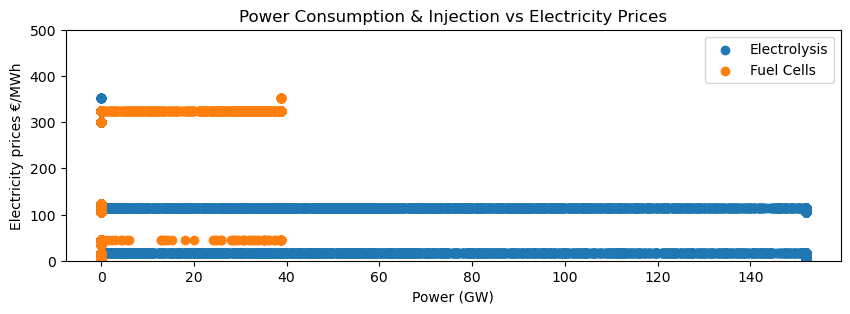

In [43]:
#Scatter plot for finding the price during power consumption/injection
fig, ax = plt.subplots(figsize=(10, 3))

ax.scatter(n1.links_t.p0['electrolysis'].div(1e3), n1.buses_t.marginal_price['electricity'],label='Electrolysis')
ax.scatter(n1.links_t.p1['fuel cell'].div(1e3).mul(-1), n1.buses_t.marginal_price['electricity'],label='Fuel Cells')
ax.legend(loc='upper right')
plt.title('Power Consumption & Injection vs Electricity Prices')
ax.set(ylim=(0,500))
ax.set_ylabel('Electricity prices €/MWh')
ax.set_xlabel('Power (GW)')

From the above plot we can see that Electrolysis tends to run when electricity prices are close to 0€/MWh or slightly above 100€/MWh
We can also see that Fuel Cells runs usually when the price is above 300€/MWh and around 50€/MWh

### (m) Major limitations of the model

Constant Hydrogen Demand is not realistic and it simplifies the model
The renewable generators are expected to produce at 100% efficiency
Solar generators have no capacity limit
We have not considered non-renewables at all in this model
It is assumed that the electrolysis/fuel cell process is instant and does not account for delays, which would possibly mean larger hydrogen storage to support the delay buffer

## Assignment 5 - Task 2 - Data Science ESM

### (a) Build models for Algeria, Argentina & Namibia

In [44]:
#Importing solar and wind factors
url = "https://model.energy/data/time-series-7302b235f1cf37e19e408c863c038290.csv"
alg_cf = pd.read_csv(url, index_col=0, parse_dates=True)
alg_cf.index = alg_cf.index + pd.DateOffset(years=4)
url = "https://model.energy/data/time-series-91c3af7cc2178900eb8c7248d0aa12c5.csv"
arg_cf = pd.read_csv(url, index_col=0, parse_dates=True)
arg_cf.index = arg_cf.index + pd.DateOffset(years=4)
url = "https://model.energy/data/time-series-57f7bbcb5c4821506de052e52d022b48.csv"
nam_cf = pd.read_csv(url, index_col=0, parse_dates=True)
nam_cf.index = nam_cf.index + pd.DateOffset(years=4)

In [45]:
#Copying and removing unwanted items from the model
n2 = n1.copy()
n2.remove('Load','demand')
n2.remove('Generator','offwind')
n2.remove('Link','fuel cell')
n2.remove('Carrier','offwind')

In [46]:
#Formula for assigning capacity factors to the model for each country's network
def countrynetwork(cty):
    n = n2.copy()
    for carrier in ['onwind','solar']:
        n.generators_t.p_max_pu[carrier] = cty[carrier]
    return n

In [47]:
#For loop to repeat for all countries
for country in ['alg','arg','nam']:
    var1 = "n_" + country
    var2 = country + "_cf"
    globals()[var1] = countrynetwork(globals()[var2])

In [48]:
n_alg.lopf(solver_name='gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.23s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\taher\AppData\Local\Temp\pypsa-problem-yrnc2die.lp
Reading time = 0.39 seconds
obj: 157680 rows, 70086 columns, 302432 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 157680 rows, 70086 columns and 302432 nonzeros
Model fingerprint: 0x9cbf9121
Coefficient statistics:
  Matrix range     [1e-03, 6e+00]
  Objective range  [1e-02, 1e+05]
  Bounds range     [2e+05, 2e+05]
  RHS range        [4e+04, 4e+04]
Presolve removed 74248 rows and 12929 columns
Presolve time: 0.21s
Presolved: 83432 rows, 57157 columns, 215256 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 1.931e+05
 Factor NZ  : 1.191e+06 (roughly 70 MB of memory)
 Factor

INFO:pypsa.linopf:Optimization successful. Objective value: 2.16e+10


('ok', 'optimal')

In [49]:
n_arg.lopf(solver_name='gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\taher\AppData\Local\Temp\pypsa-problem-sa_5vv5i.lp
Reading time = 0.32 seconds
obj: 157680 rows, 70086 columns, 302381 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 157680 rows, 70086 columns and 302381 nonzeros
Model fingerprint: 0x3f869674
Coefficient statistics:
  Matrix range     [1e-03, 6e+00]
  Objective range  [1e-02, 1e+05]
  Bounds range     [2e+05, 2e+05]
  RHS range        [4e+04, 4e+04]
Presolve removed 74299 rows and 12980 columns
Presolve time: 0.18s
Presolved: 83381 rows, 57106 columns, 215103 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 1.930e+05
 Factor NZ  : 1.190e+06 (roughly 70 MB of memory)
 Factor

INFO:pypsa.linopf:Optimization successful. Objective value: 1.87e+10


('ok', 'optimal')

In [50]:
n_nam.lopf(solver_name='gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\taher\AppData\Local\Temp\pypsa-problem-6rhdy_o5.lp
Reading time = 0.36 seconds
obj: 157680 rows, 70086 columns, 302176 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 157680 rows, 70086 columns and 302176 nonzeros
Model fingerprint: 0x3848bbef
Coefficient statistics:
  Matrix range     [1e-03, 6e+00]
  Objective range  [1e-02, 1e+05]
  Bounds range     [2e+05, 2e+05]
  RHS range        [4e+04, 4e+04]
Presolve removed 74504 rows and 13185 columns
Presolve time: 0.20s
Presolved: 83176 rows, 56901 columns, 214488 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 1.926e+05
 Factor NZ  : 1.186e+06 (roughly 70 MB of memory)
 Factor

INFO:pypsa.linopf:Optimization successful. Objective value: 2.32e+10


('ok', 'optimal')

### (b) Country comparisons

#### (i) Average hydrogen production cost

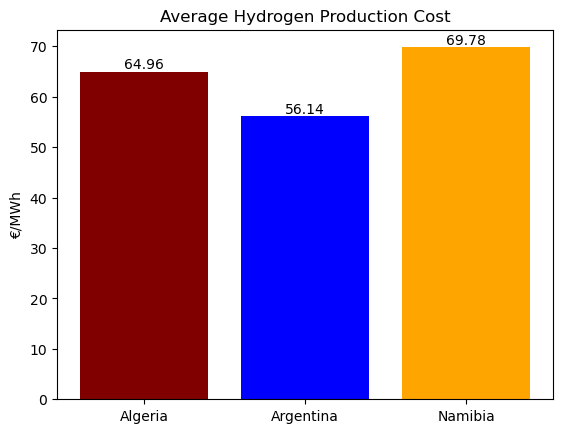

In [51]:
#Finding Hydrogen production price by total system cost/333TWh (Using loads values for reaffirmation and to avoid manual values)
algprice = (n_alg.objective / n_alg.loads_t.p.sum()).item()
argprice = (n_arg.objective / n_arg.loads_t.p.sum()).item()
namprice = (n_nam.objective / n_nam.loads_t.p.sum()).item()

plt.bar(['Algeria','Argentina','Namibia'],[algprice,argprice,namprice], color=['maroon','blue','orange'],)
plt.title('Average Hydrogen Production Cost')
plt.ylabel('€/MWh')

for i, v in enumerate([algprice,argprice,namprice]):
    plt.text(i, v, round(v,2), ha='center', va='bottom')

#### (ii) Optimal capacities built

In [66]:
n_nam.objective/1e9

23.237931066466587

In [52]:
x = n.generators.p_nom_opt.div(1e3)
x = x.append(n.storage_units.p_nom_opt.div(1e3))
x = x.to_frame()
x = x.rename(columns={'p_nom_opt': 'Original'})
y = n1.generators.p_nom_opt.div(1e3)
y = y.append(n1.storage_units.p_nom_opt.div(1e3))
x['WithConstraints'] = y

In [53]:
df = n_alg.statistics()
df = df['Optimal Capacity'].div(1e3) #GW
df = df.to_frame()
df = df.rename(columns={'Optimal Capacity':'Algeria'})
x = n_arg.statistics()
x = x['Optimal Capacity']
df['Argentina'] = x.div(1e3) #GW
x = n_nam.statistics()
x = x['Optimal Capacity']
df['Namibia'] = x.div(1e3) #GW
df # Below table gives the capacities for each country in GW

Algeria    Argentina      Namibia
            carrier                                                 
Generator   onwind              102.675601   130.250750     0.000000
            solar               117.232142    21.509298   300.536986
Link        electrolysis         89.300479    76.587441   160.787288
Load        hydrogen                   NaN          NaN          NaN
StorageUnit battery storage       0.000000     0.000000     0.000000
Store       hydrogen storage  10548.252686  5391.956576  8686.908492

#### (iii) Average Utilisation rate

In [54]:
#Calculations for each countr's utilisation rate
electroutil_alg = n_alg.links_t.p1['electrolysis'].div(1e3).mul(-1)
electroutil_alg = electroutil_alg.to_frame()
electroutil_alg['Utilisation (%)'] = (electroutil_alg['electrolysis'] / electroutil_alg['electrolysis'].max()) * 100
util_alg = electroutil_alg['Utilisation (%)'].mean()

electroutil_arg = n_arg.links_t.p1['electrolysis'].div(1e3).mul(-1)
electroutil_arg = electroutil_arg.to_frame()
electroutil_arg['Utilisation (%)'] = (electroutil_arg['electrolysis'] / electroutil_arg['electrolysis'].max()) * 100
util_arg = electroutil_arg['Utilisation (%)'].mean()

electroutil_nam = n_nam.links_t.p1['electrolysis'].div(1e3).mul(-1)
electroutil_nam = electroutil_nam.to_frame()
electroutil_nam['Utilisation (%)'] = (electroutil_nam['electrolysis'] / electroutil_nam['electrolysis'].max()) * 100
util_nam = electroutil_nam['Utilisation (%)'].mean()

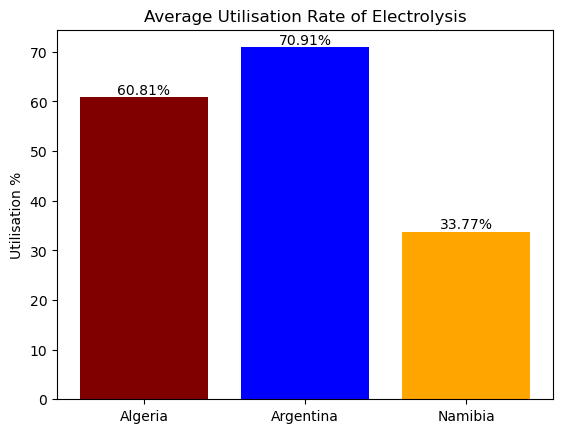

In [55]:
plt.bar(['Algeria','Argentina','Namibia'],[util_alg,util_arg,util_nam], color=['maroon','blue','orange'],) # Plot for visualising the differences
plt.title('Average Utilisation Rate of Electrolysis')
plt.ylabel('Utilisation %')

for i, v in enumerate([util_alg,util_arg,util_nam]):
    plt.text(i, v, f"{round(v,2)}%", ha='center', va='bottom')

From the above analysis we can observe -
    * Argentina can produce the required Hydrogen at a much cheaper price than other two countries
    * This is also confirmed when we observe the optimal capacities we need to build for each omponent of our system.
        * Argentina requires the smallest Hydrogen storage as it can consistently meet demand without much excess
        * Argentina relies heavily on onwind power, whereas Namibia does not use its onwind generators due to low capacity factors and high capital costs of onwind plants
        * Namibia heavily relies on solar instead whereas Argentina utilizes solar the least
        * Even the electrolysis capacity is very high for Namibia, approx 2xArgentina's capacity
        * Algeria utilizes both wind and solar power, however requires the largest hydrogen storage to meet the import demand.
    * When we analyse the utilisation rate we can also observe that the utilisation rate of Namibia 33.8% is very poor compared to both Argentina and Algeria. Argentina has a high 71% utilisation rate of electrolysis.

From the above analysis we can see that the Argentina is the best possible import option for Hydrogen. However, considering the distance between countries, we will have to reevaluate our conclusion once transport costs are taken into account.



### (c) Transportation costs

In [56]:
#Distance from Germany
algd = 3500
argd = 13000
namd = 10000

In [57]:
# Transport price calculations
algtransport = 30 + 0.001*algd
algfinalprice = algprice + algtransport
print(f"Algeria hydrogen price including transportation is {algfinalprice:0.2f} €/MWh")

Algeria hydrogen price including transportation is 98.46 €/MWh


In [58]:
argtransport = 30 + 0.001*argd
argfinalprice = argprice + argtransport
print(f"Argentina hydrogen price including transportation is {argfinalprice:0.2f} €/MWh")

Argentina hydrogen price including transportation is 99.14 €/MWh


In [59]:
namtransport = 30 + 0.001*namd
namfinalprice = namprice + namtransport
print(f"Namibia hydrogen price including transportation is {namfinalprice:0.2f} €/MWh")

Namibia hydrogen price including transportation is 109.78 €/MWh


In [60]:
print(f"From above analysis we can see that Algeria can import Hydrogen at the lowest price of {algfinalprice:0.2f} €/MWh.\n"
      f"Argentina is a close alternative with a price of {argfinalprice:0.2f} €/MWh, which is only{((argfinalprice-algfinalprice)/algfinalprice)*100: 0.2f}% more than Algeria.\n"
      f"Namibia has the highest costs compared to other two countries at {namfinalprice:0.2f} €/MWh, which is {((namfinalprice-algfinalprice)/algfinalprice)*100: 0.2f}% more than Algeria.")

From above analysis we can see that Algeria can import Hydrogen at the lowest price of 98.46 €/MWh.
Argentina is a close alternative with a price of 99.14 €/MWh, which is only 0.70% more than Algeria.
Namibia has the highest costs compared to other two countries at 109.78 €/MWh, which is  11.50% more than Algeria.


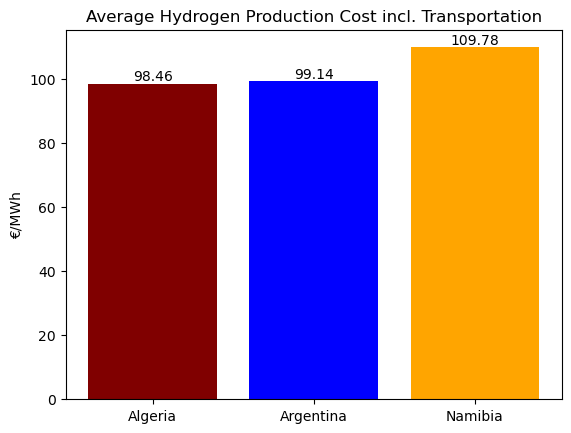

In [61]:
plt.bar(['Algeria','Argentina','Namibia'],[algfinalprice,argfinalprice,namfinalprice], color=['maroon','blue','orange'],)
plt.title('Average Hydrogen Production Cost incl. Transportation')
plt.ylabel('€/MWh')

for i, v in enumerate([algfinalprice,argfinalprice,namfinalprice]):
    plt.text(i, v, round(v,2), ha='center', va='bottom')

### (d) Limitations of the model

We are assuming the hydrogen demand is being imported immediately, however in order to transport hydrogen such long distances we need much larger storages which would significantly raise prices of this system
It is assuming that all renewable energy produced by exporting country is going to be utilised for hydrogen conversion and the efficiencies are all assumed to be 100%